In [1]:
import pandas as pd

In [2]:
import sys
sys.path.insert(0,'./')

In [3]:
from kappa_cl import *
from fisher import *

In [26]:
z=np.linspace(0,5,200)
pzs=lsst_zsource(z=z)
x=z<2
z=z[x]
pzs=pzs[x]

nbins=1
zs_bins=np.linspace(0.3,2,nbins+1)
nbins=3
zl_bins=np.linspace(0.3,1.8,nbins+1)
lmax_cl=5000
lmin_cl=2
l_step=10
l=np.arange(lmin_cl,lmax_cl,step=l_step)
l0=np.arange(lmin_cl,lmax_cl)
#l_bins=np.int64(np.linspace(lmin_cl,lmax_cl,20))#
lmin_clB=lmin_cl+10
lmax_clB=lmax_cl-100
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_clB),np.log10(lmax_clB),Nl_bins))
lb=np.sqrt(l_bins[1:]*l_bins[:-1])
if l_step!=1:
    l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20)))

do_cov=True
bin_cl=True

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)
stack_data=False

ns0=26
ns=ns0*pzs*np.gradient(z)+np.inf

In [7]:
kappa0=Kappa(zs={0:[1]},pzs={0:[1]},lens_weight=False,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0,
               stack_data=stack_data,SSV_cov=True,tidal_SSV_cov=True,ns={0:[26]},f_sky=0.35)
kappa1=Kappa(zs={0:[1]},pzs={0:[1]},lens_weight=False,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l,
               stack_data=stack_data,SSV_cov=True,tidal_SSV_cov=True,ns={0:[26]},f_sky=0.35)

# l are different in kappa0 and kappa1. To test if we can get aways with computation at fewer l, when binning
# with l_bins. Remeber, cl and cov are computed at some l first and then binned.

In [8]:
%time cl0=kappa0.kappa_cl_tomo()
%time cl1=kappa1.kappa_cl_tomo()

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


CPU times: user 10.6 s, sys: 1.48 s, total: 12 s
Wall time: 9.87 s


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


CPU times: user 6.44 s, sys: 50.6 ms, total: 6.49 s
Wall time: 6.46 s


In [9]:
cc=kappa0.cov_utils

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


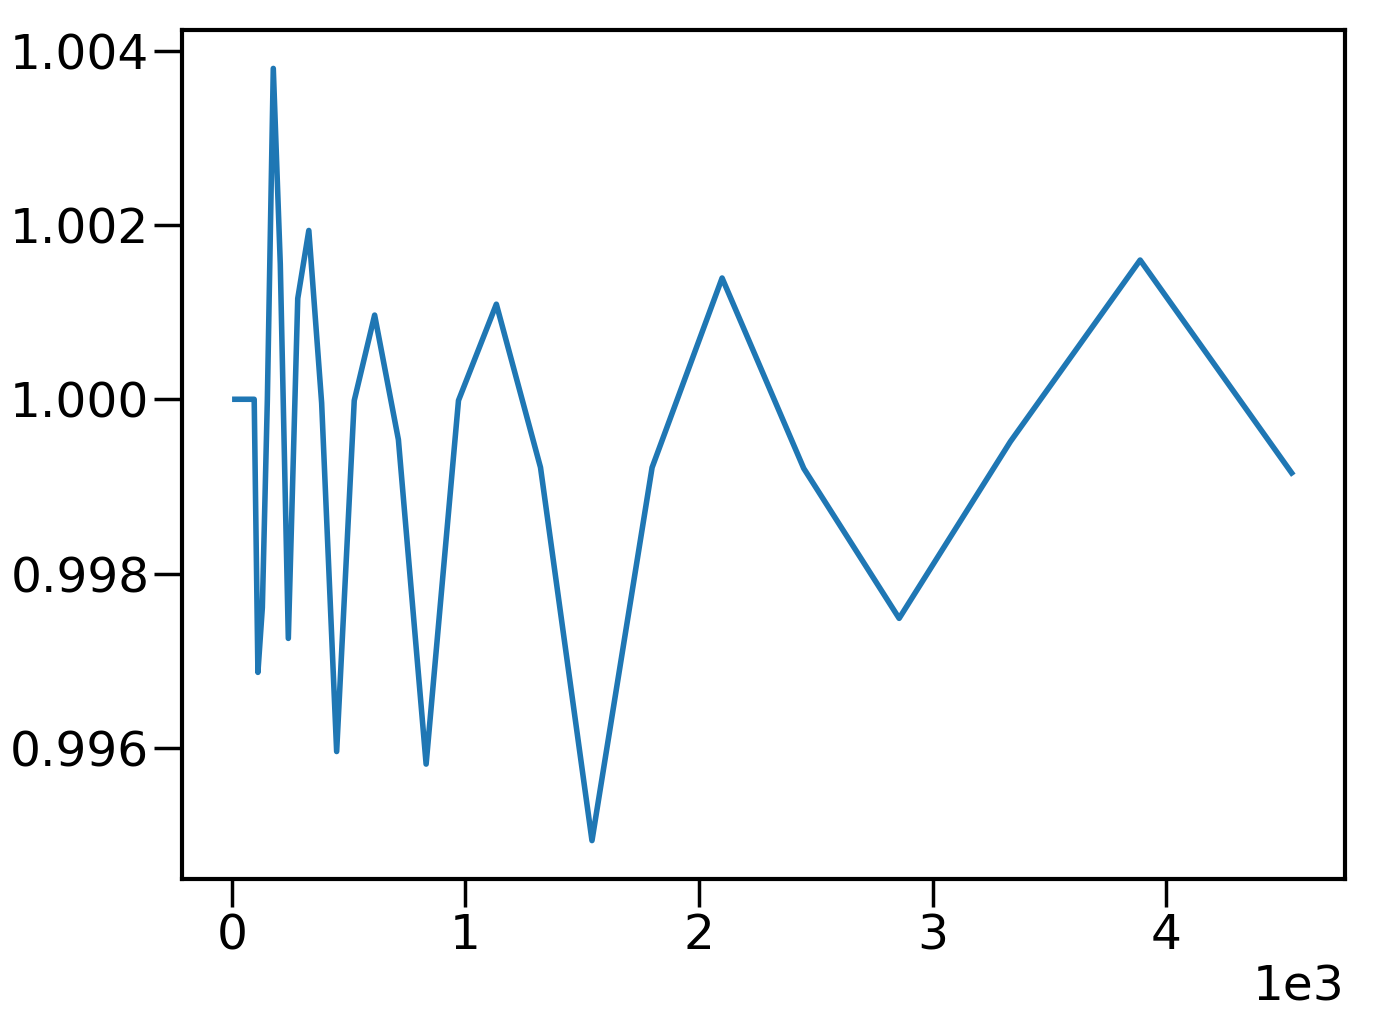

In [10]:
cl_t=cl0['cl'][:,0,0]
cl_t2=cl1['cl'][:,0,0]
plot(lb,cl_t/cl_t2)

# xscale('log')
# ylim(8e-7,8.6e-7)
#yscale('log')

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


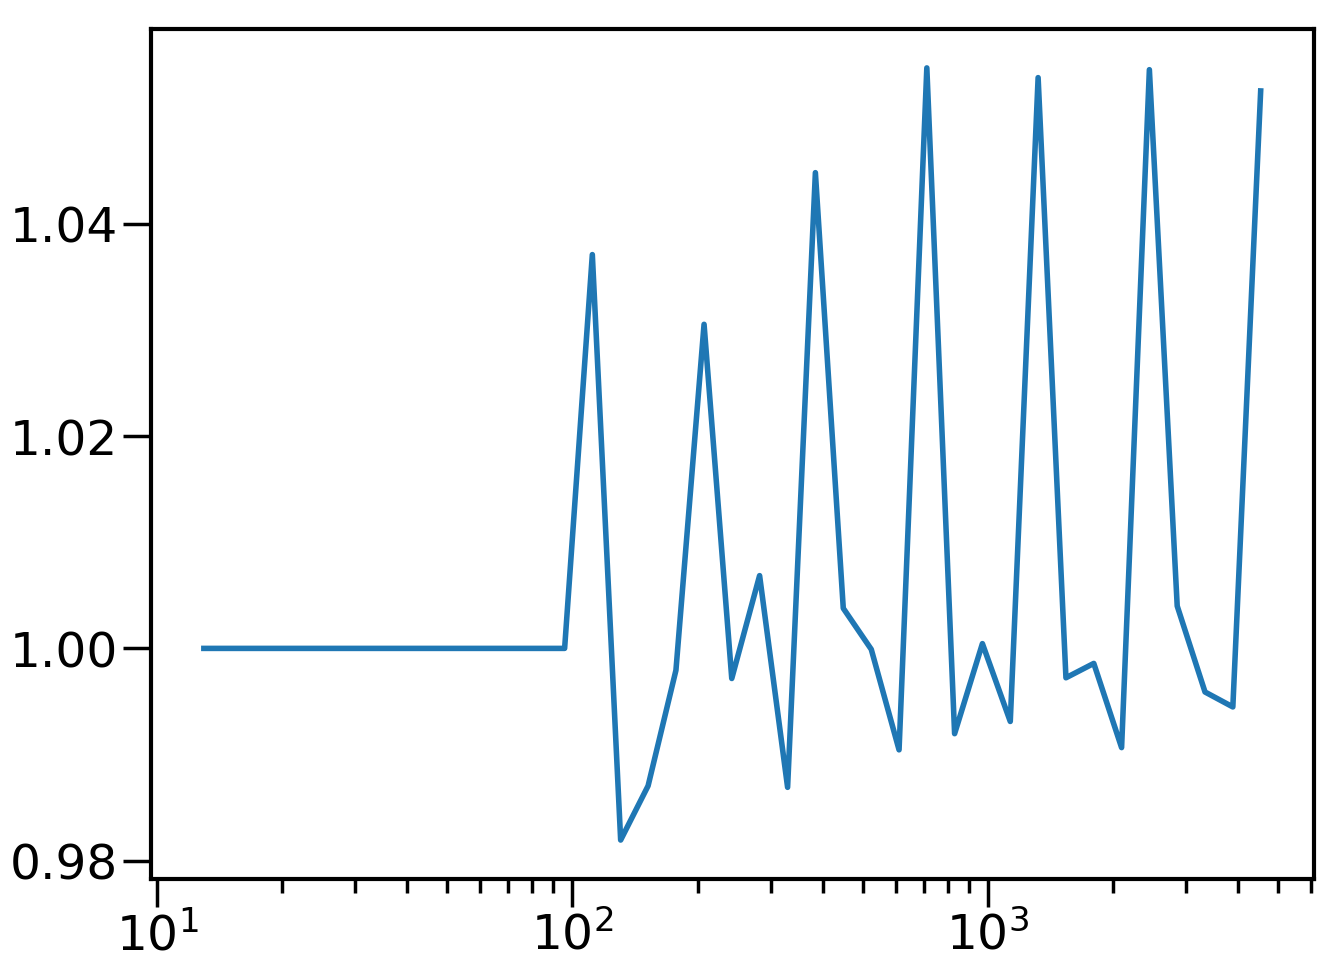

In [11]:
cov0=cl0['cov'][(0,0,0,0)]
cov02=cl1['cov'][(0,0,0,0)]
plot(lb,np.diag(cov02['G'])/np.diag(cov0['G']))
xscale('log')
#ylim(0.99,1.01)

(10, 3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


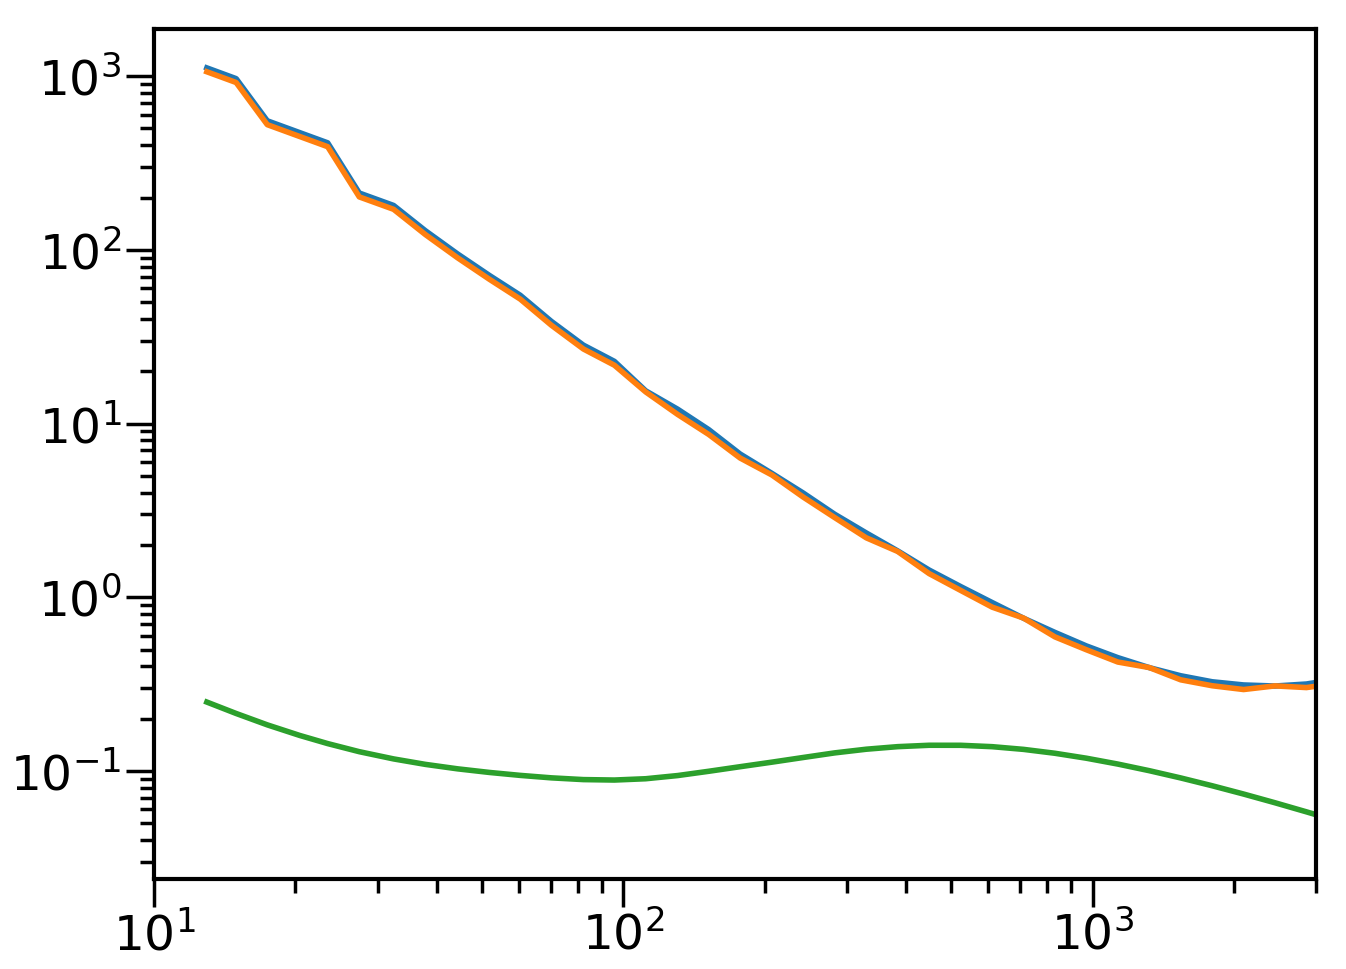

In [12]:
#cov0=clS['cov'][(0,0,0,0)]
f=1.e4
plot(lb,np.diag(cov0['G'])/cl_t**2*f)
plot(lb,np.diag(cov02['G'])/cl_t**2*f*0.95)
plot(lb,np.diag(cov0['SSC_dd'])/cl_t**2*f)
xscale('log')
yscale('log')
xlim(10,3000)

(12, 4900)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


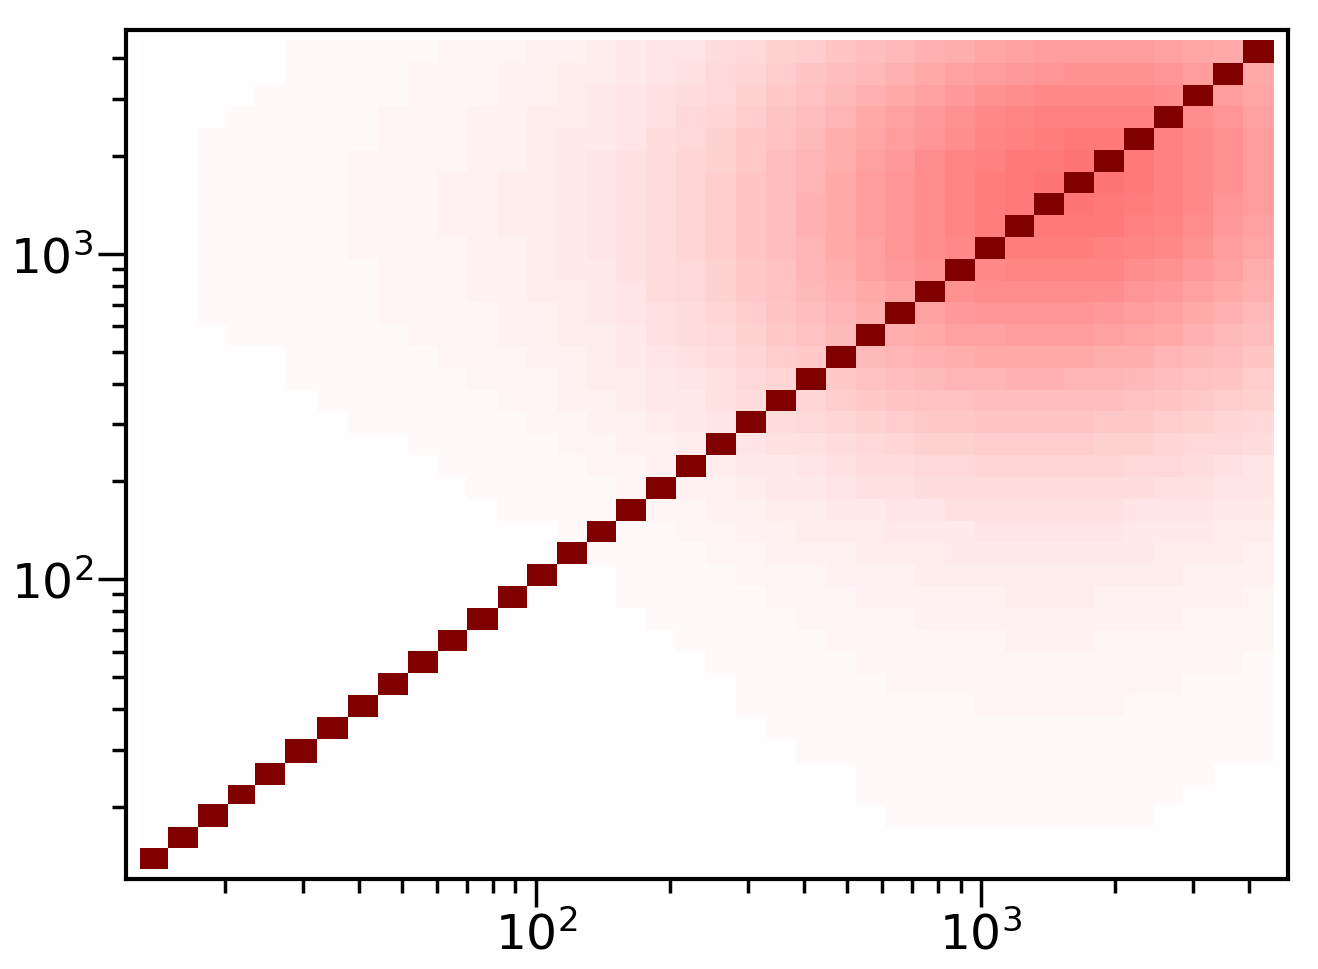

In [13]:
cov0=cl0['cov'][(0,0,0,0)]
corr2=kappa0.cov_utils.corr_matrix(cov0['final'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(lmin_clB,lmax_clB)
ylim(lmin_clB,lmax_clB)

In [14]:
np.sum(ns)

22.894045125394292

In [27]:
kappaS = Kappa(zs=z,pzs=pzs,l=l,z_bins=zs_bins,lens_weight=False,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
               stack_data=stack_data,SSV_cov=True,tidal_SSV_cov=True,ns=ns)#ns=np.inf)

kappaL = Kappa(zs=z,pzs=pzs,l=l,z_bins=zl_bins,lens_weight=True,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
               stack_data=stack_data,SSV_cov=True,tidal_SSV_cov=True,ns=ns)#ns=np.inf)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


In [28]:
%time clS=kappaS.kappa_cl_tomo()
clL=kappaL.kappa_cl_tomo()
clSb=clS#['binned']
clLb=clL#['binned']
#lb=clS['binned']['l']
# l=clS['l']

CPU times: user 6.36 s, sys: 57.9 ms, total: 6.42 s
Wall time: 6.24 s


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


In [29]:
kappaS.SN

array([[[ 0.]]])

In [30]:
kappaL.SN

array([[[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]])

In [31]:
cl_b_stack=kappaS.stack_dat(clS)
cl_Lb_stack=kappaL.stack_dat(clL)
#clstack=kappaS.stack_dat(clS)

In [32]:
covS_inv=np.linalg.inv(cl_b_stack['cov'])
print (np.sqrt(np.dot(cl_b_stack['cl'],np.dot(covS_inv,cl_b_stack['cl']))))
covL_inv=np.linalg.inv(cl_Lb_stack['cov'])
print (np.sqrt(np.dot(cl_Lb_stack['cl'],np.dot(covL_inv,cl_Lb_stack['cl']))))

382.708903078
703.686731807


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


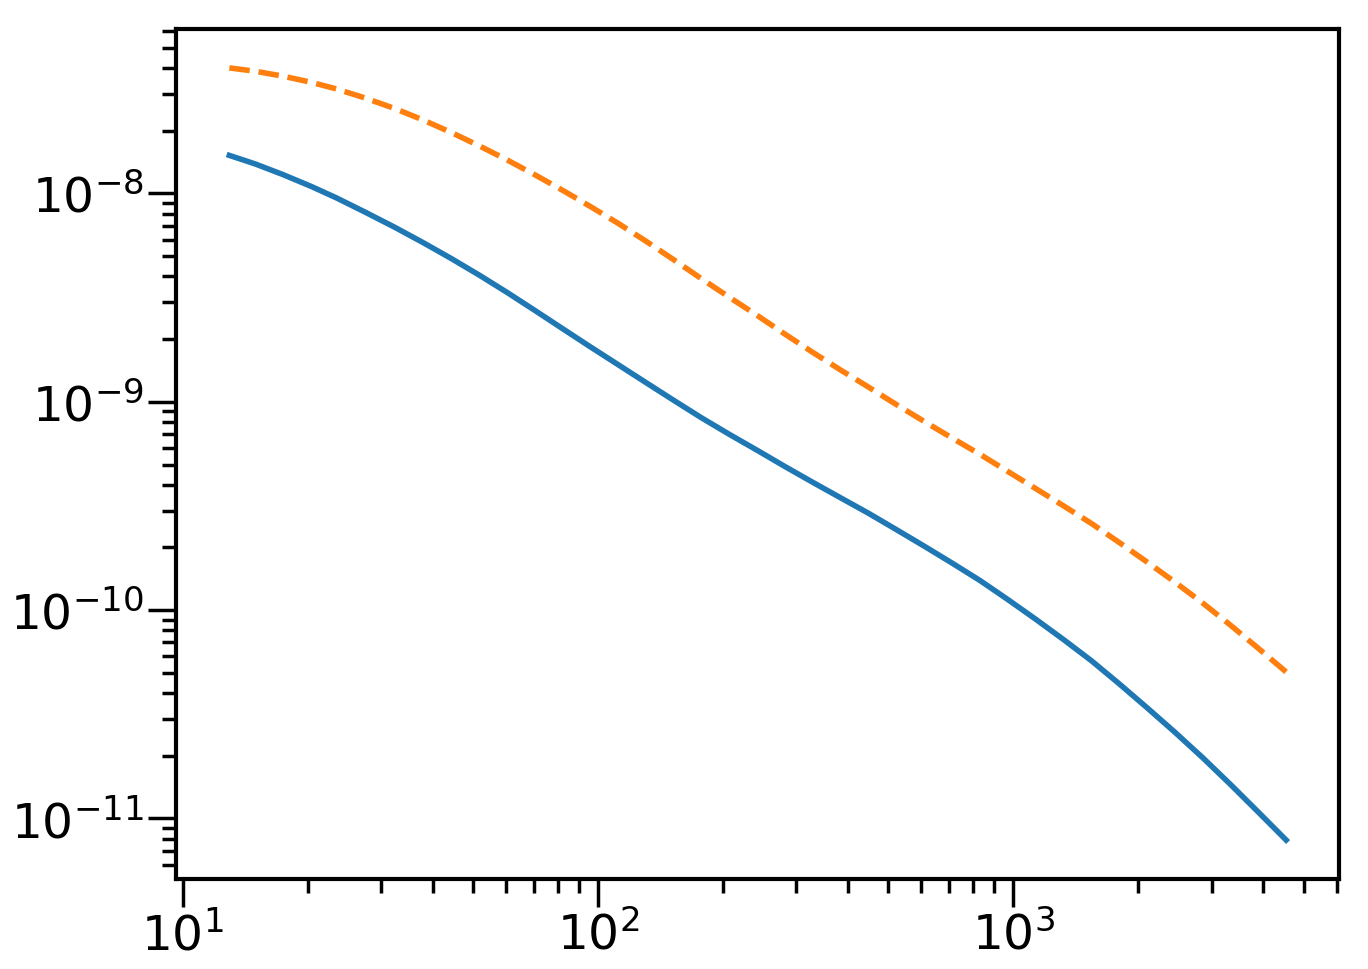

In [36]:
plot(clS['l'],clS['cl'][:,0,0])
#plot(clSb['l'],clSb['cl'][:,0,0])

plot(clL['l'],clL['cl'][:,0,0],ls='--')
# plot(clLb['l'],clLb['cl'][:,0,0])
xscale('log')
yscale('log')

In [21]:
corr=cc.corr_matrix(cl_b_stack['cov'])
corrL=cc.corr_matrix(cl_Lb_stack['cov'])

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


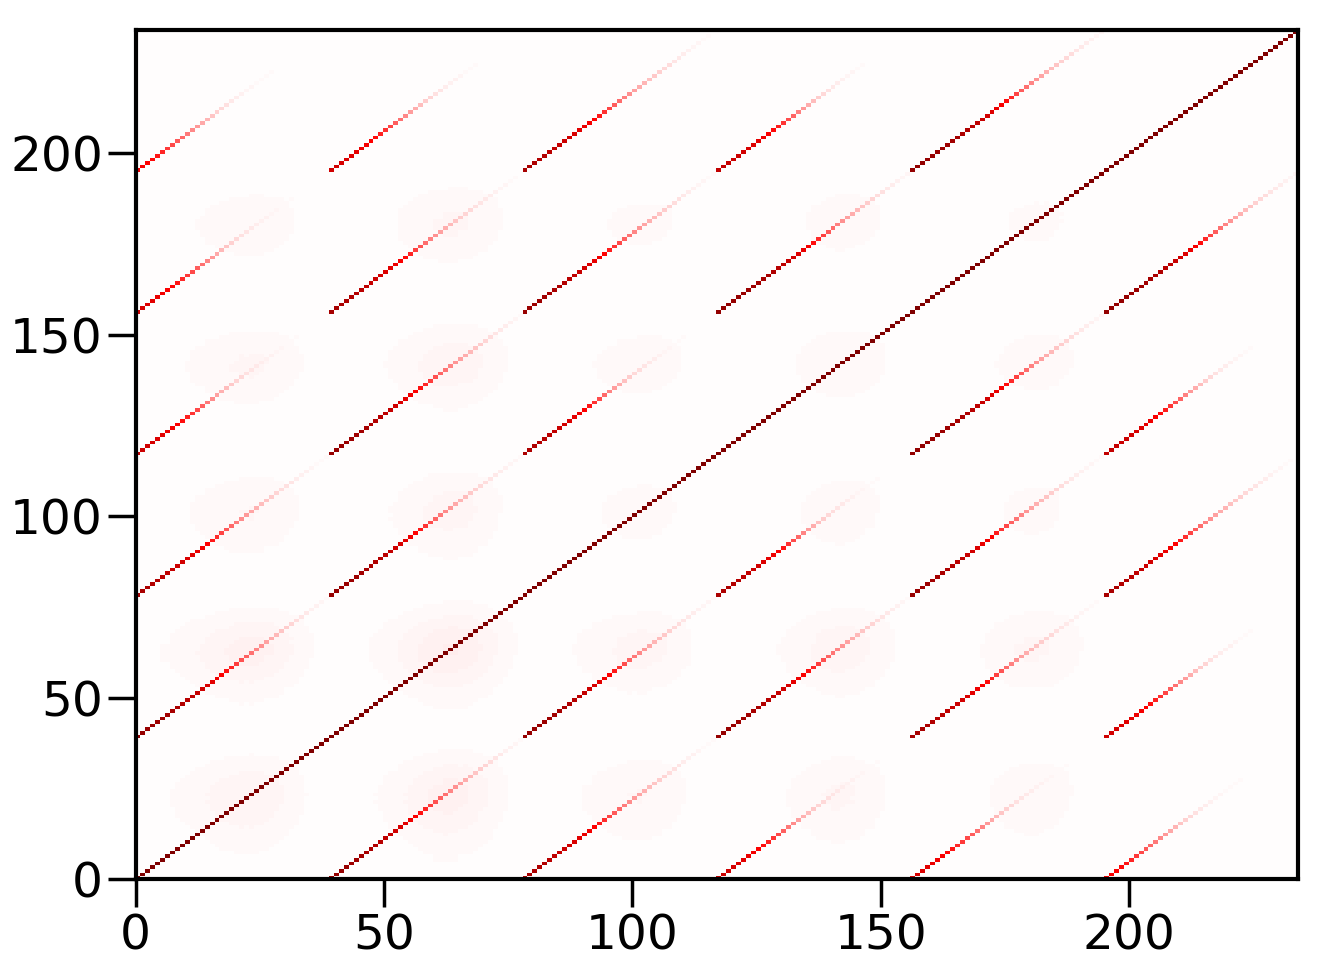

In [22]:
pcolor(corr,vmin=-1,vmax=1,cmap='seismic')

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


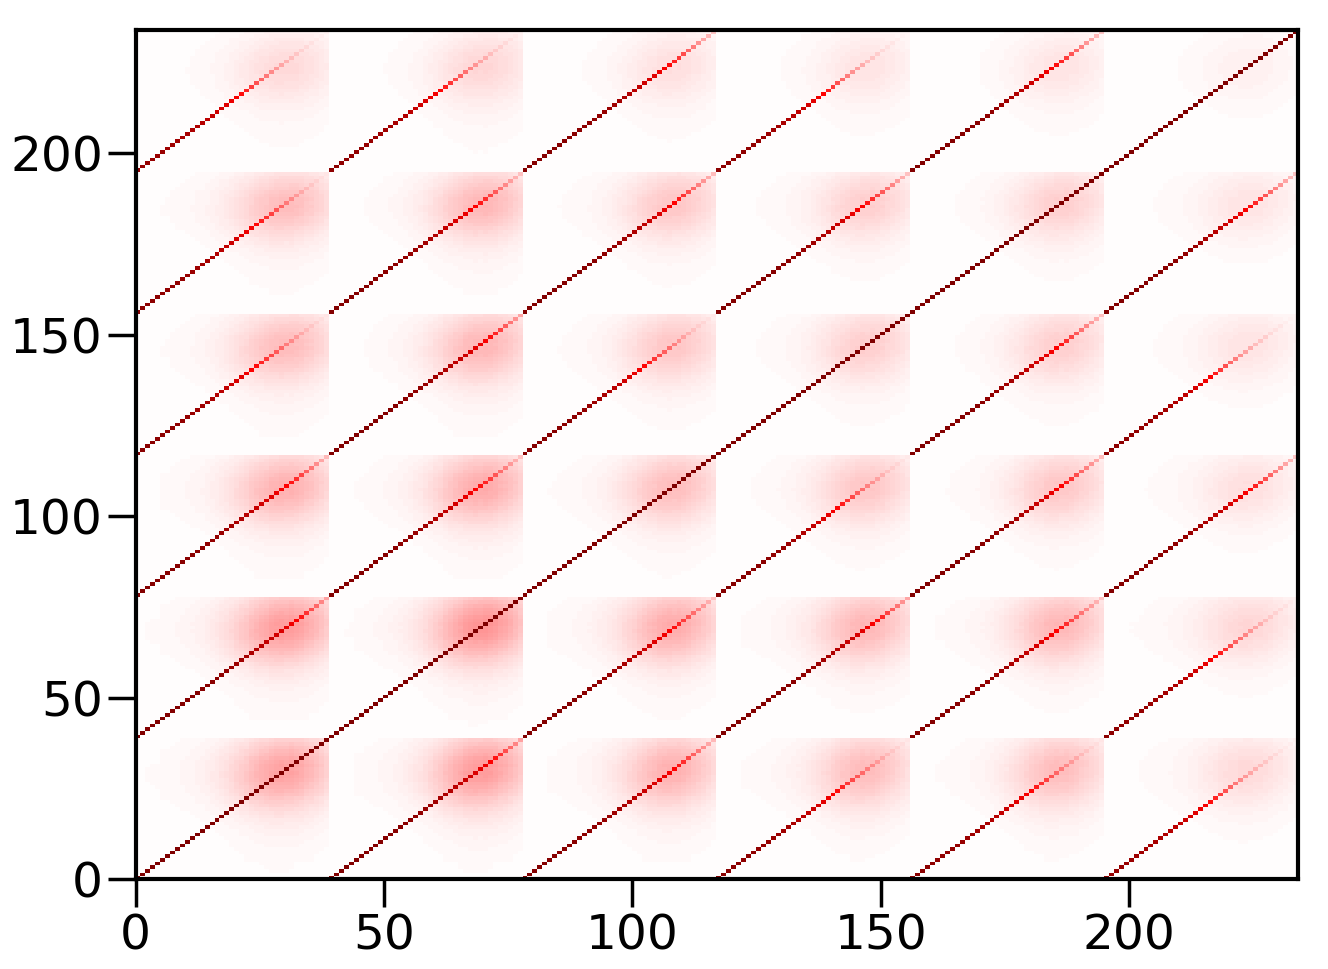

In [23]:
pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

(10, 3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


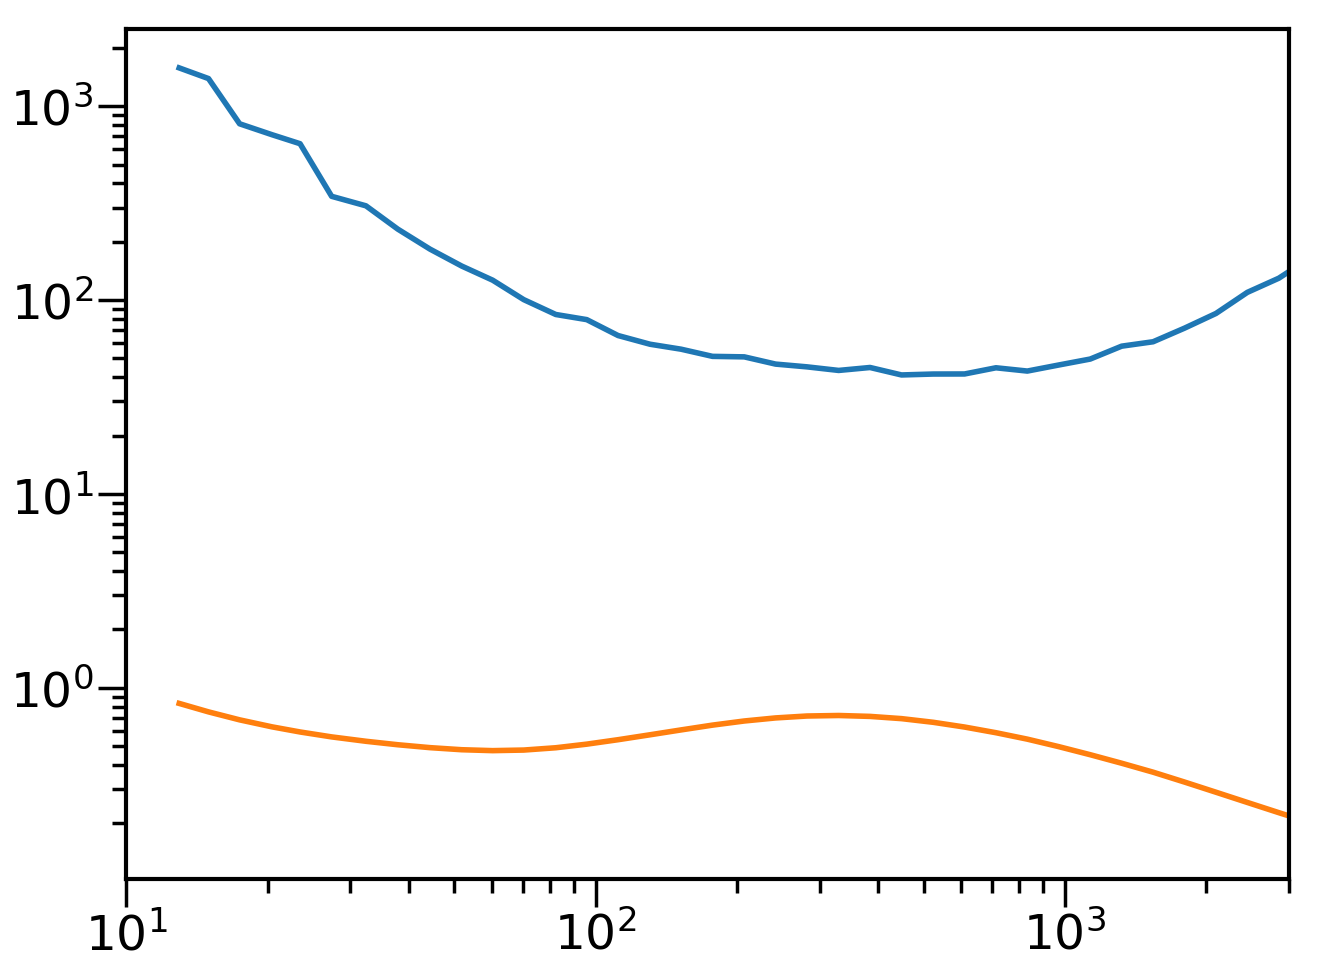

In [24]:
#cov0=clS['cov'][(0,0,0,0)]
f=1.e4
cl00=clSb
cl01=clS
cov0=cl00['cov'][(0,0,0,0)]
cov01=cl01['cov'][(0,0,0,0)]
cl_t=cl00['cl'][:,0,0]
cl_t1=cl01['cl'][:,0,0]
plot(lb,np.diag(cov0['G'])/cl_t**2*f)
plot(lb,np.diag(cov0['SSC_dd'])/cl_t**2*f)
# plot(l,np.diag(cov01['G'])/cl_t1**2*f)
# plot(l,np.diag(cov01['SSC_dd'])/cl_t1**2*f)
xscale('log')
yscale('log')
xlim(10,3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


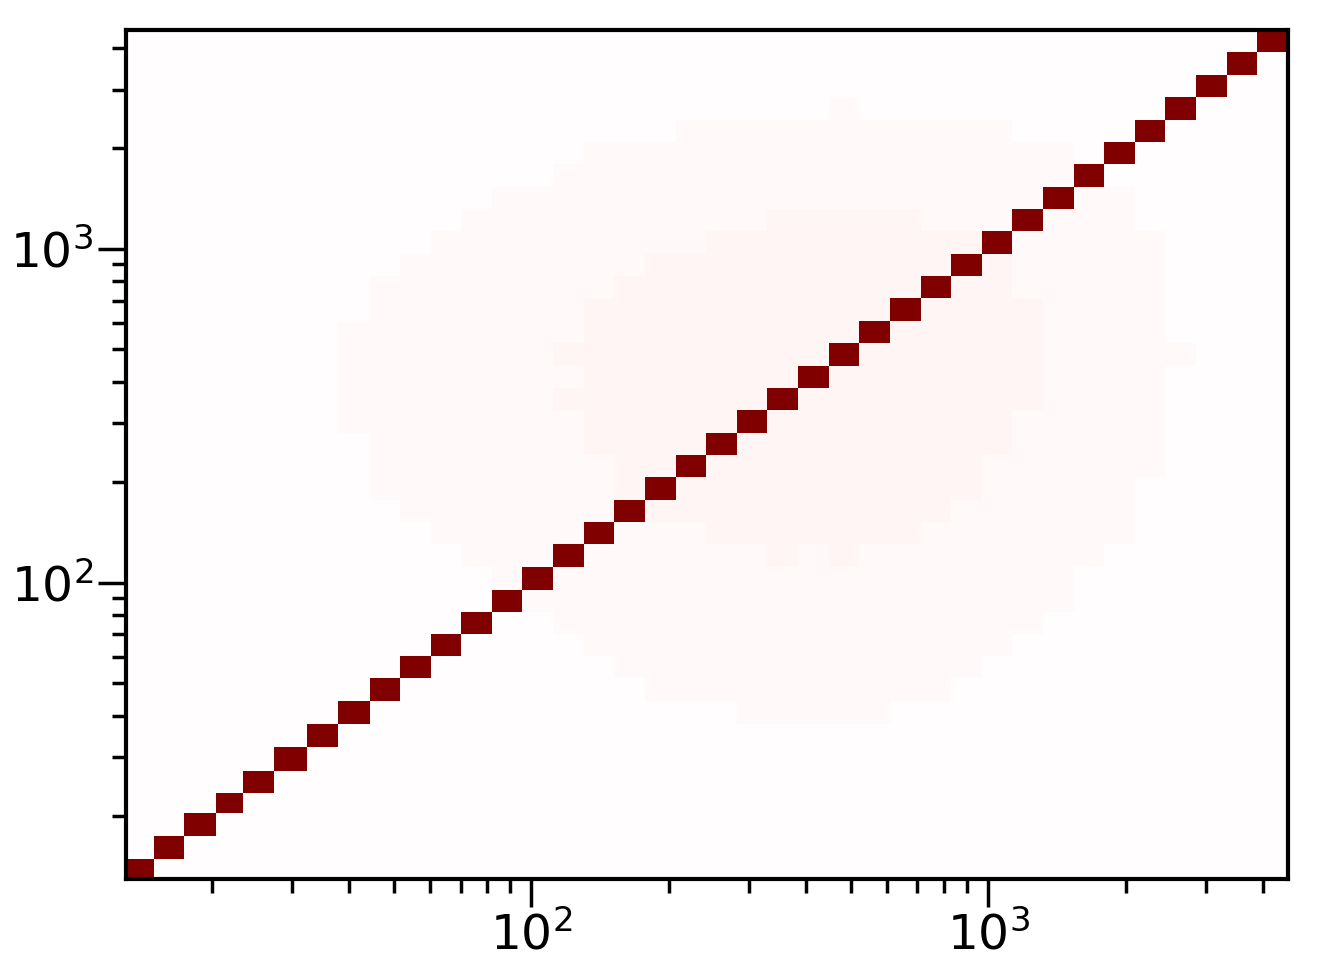

In [25]:
corr2=cc.corr_matrix(cov0['final'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

(10, 3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


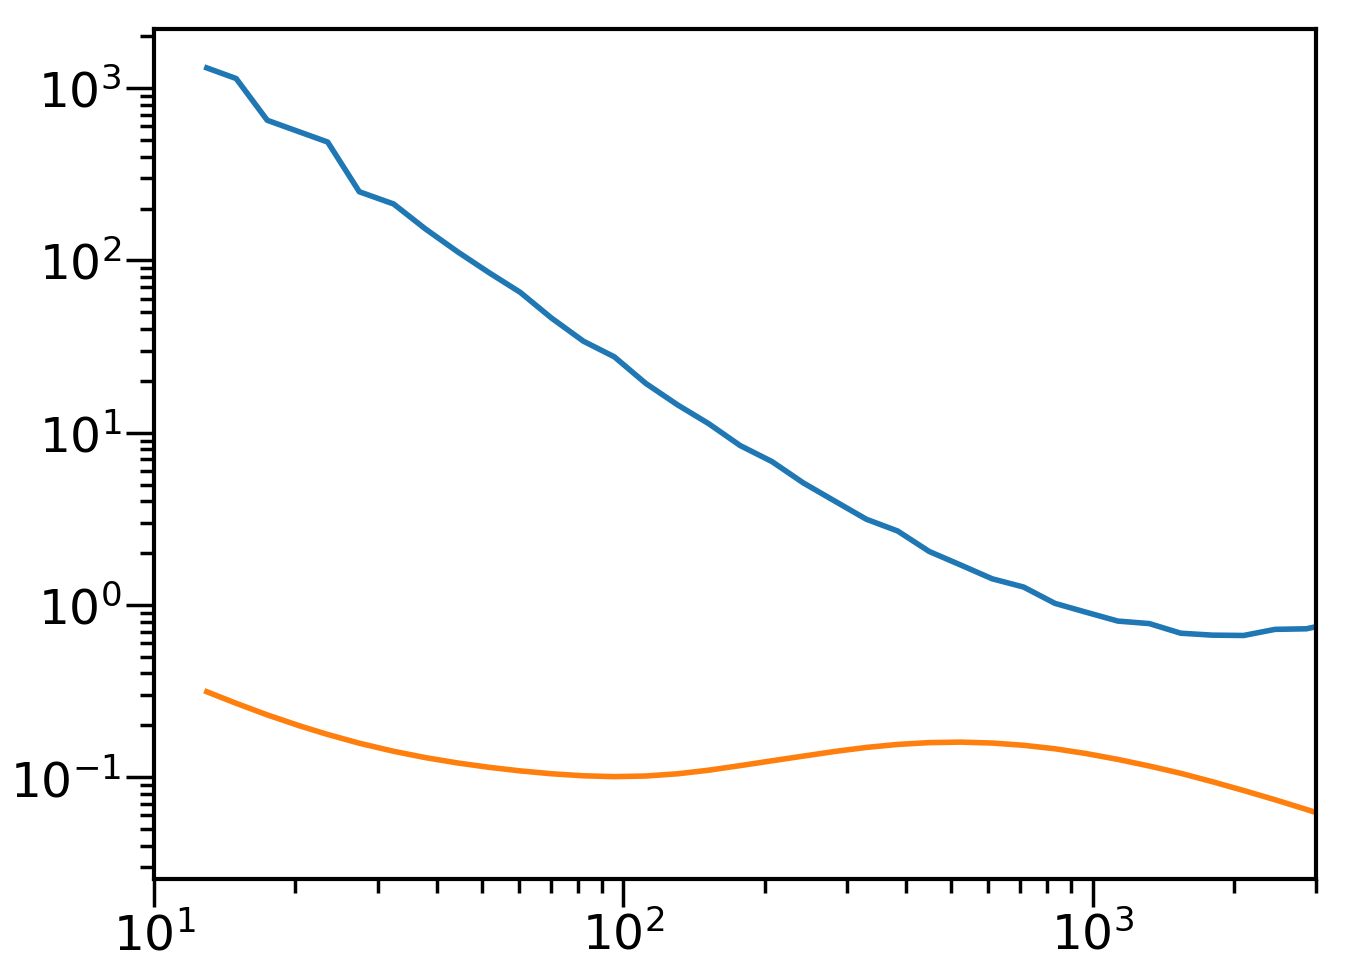

In [26]:
#cov0=clS['cov'][(0,0,0,0)]
f=1.e4
cl00=clLb
cl01=clL
cov0=cl00['cov'][(0,0,0,0)]
cov01=cl01['cov'][(0,0,0,0)]
cl_t=cl00['cl'][:,0,0]
cl_t1=cl01['cl'][:,0,0]
plot(lb,np.diag(cov0['G'])/cl_t**2*f)
plot(lb,np.diag(cov0['SSC_dd'])/cl_t**2*f)
# plot(l,np.diag(cov01['G'])/cl_t1**2*f)
# plot(l,np.diag(cov01['SSC_dd'])/cl_t1**2*f)
xscale('log')
yscale('log')
xlim(10,3000)